**Seyun Kim, Lucia Rhode, Nishat Ahmed**

ECE475 Frequentist Machine Learning Project 1

**Part 1**

In [1]:
import sys

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [2]:
from google.colab import files
data_file = files.upload()



Saving prostate_data.csv to prostate_data (4).csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(data_file['prostate_data.csv']), index_col=0)

In [4]:
# Import data, convert to numpy arrays, and preprocess string ground truth to ints

feature_names = ["Intercept"] + [d for d in data.columns if d != 'train' and d != 'lpsa']

train_data = np.concatenate((np.ones((data.shape[0],1)), data[list(col for col in data.columns if col != 'train' and col != 'lpsa')].to_numpy()), axis=1)
test_data = data['lpsa'].to_numpy().reshape((len(data),1))


In [5]:
feature_names

['Intercept',
 'lcavol',
 'lweight',
 'age',
 'lbph',
 'svi',
 'lcp',
 'gleason',
 'pgg45']

In [6]:
# Normalize train data
def normalize(x, mean, std):
  for i in range(1, x.shape[1]):
    #x[:,i] = (x[:,i] - np.mean(x_train[:,i])) / (np.std(x_train[:,i]) + 1e-5)
    x[:,i] = (x[:,i] - mean[i]) / (std[i] + 1e-5)
  return x

In [7]:
# Split data
# train, val, test size : 97, 11, 11
x_train, x_test, y_train, y_test= train_test_split(train_data, test_data, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5)


In [8]:
# Normalize train, validation, and test features
x_train_mean = np.zeros(x_train.shape[1])
x_train_std = np.zeros(x_train.shape[1])
for i in range(1, x_train.shape[1]):
  x_train_mean[i] = np.mean(x_train[:,i])
  x_train_std[i] = np.std(x_train[:,i])

x_train = normalize(x_train, x_train_mean, x_train_std)
x_val = normalize(x_val, x_train_mean, x_train_std)
x_test = normalize(x_test, x_train_mean, x_train_std)

In [9]:
def beta_hat_func(x, y):
  term1 = np.matmul(np.linalg.inv(np.matmul(np.transpose(x), x)), np.transpose(x))

  return np.matmul(term1, y)

In [10]:
def error(x, y, beta):
  y_hat = np.matmul(x, beta)
  rss = np.matmul(np.transpose(y - y_hat), y - y_hat)
  return rss

In [11]:
beta_hat = beta_hat_func(x_train, y_train)

In [12]:
# Report train vs test error
y_hat = np.matmul(x_train, beta_hat)
mse_plain = mean_squared_error(y_hat, y_train)

print("Mean squared error on training set: ", mse_plain)

# Report test error
y_hat = np.matmul(x_test, beta_hat)
mse_plain = mean_squared_error(y_hat, y_test)

print("Mean squared error on test set: ", mse_plain)

Mean squared error on training set:  0.42054657698467385
Mean squared error on test set:  0.45976766929164575


Mean squared error on training set is 0.42054657698467385 and Mean squared error on test set is 0.45976766929164575. MSE on test is slightly higher than train MSE and errors are generally low so this is good.

In [13]:
# Print Table 3.1. Correlations of predictors in the prostate cancer data
table_31 = [[""] + [feat for feat in feature_names[1:-1]]]
for i in range(2, len(feature_names)): # row
  temp = [feature_names[i]]
  for j in range(1, i): # col
    temp.append(str(np.round(pearsonr(x_train[:,i], x_train[:,j])[0], 2)))
  table_31.append(temp)

print(tabulate(table_31, headers='firstrow'))

           lcavol    lweight    age    lbph    svi    lcp    gleason
-------  --------  ---------  -----  ------  -----  -----  ---------
lweight      0.26
age          0.27       0.34
lbph         0.04       0.42   0.34
svi          0.48       0.11   0.06   -0.08
lcp          0.58       0.13   0.15   -0.03   0.68
gleason      0.39      -0.03   0.26    0.03   0.29   0.49
pgg45        0.38       0.09   0.3     0.06   0.44   0.64       0.73


This table shows the correlation between every two variables and the values seem to agree with what's on the textbook.



In [14]:
# Compute z score
z_score = [0.0 for _ in range(len(feature_names))]
x_squared = np.linalg.inv(np.matmul(np.transpose(x_train), x_train))
N = x_train.shape[0]
p = x_train.shape[1]
var = 1/(N-p-1)*np.sum((y_test - y_hat)**2)
stdev = np.sqrt(var)

beta_hat = beta_hat.reshape(9)

std_error = [0 for _ in range(len(feature_names))]
# for i in range(len(std_error)):
#   std_error[i] = np.round(np.std(x_train[:,i]) / len(x_train), 2)

for i in range(len(z_score)):
  z_score[i] = np.round(beta_hat[i] / (stdev*np.sqrt(x_squared[i, i])), 2)  


In [15]:
# Print table 3.2
table = [["Term", "Coefficient", "Std Error", "Z Score"]]
for i in range(len(feature_names)):
  table.append([feature_names[i], str(beta_hat[i]), str(np.round(x_train_std[i]/len(x_train),2)), str(z_score[i])])
print(tabulate(table, headers='firstrow'))

Term         Coefficient    Std Error    Z Score
---------  -------------  -----------  ---------
Intercept      2.40836           0         80.67
lcavol         0.585789          0.01      14.8
lweight        0.259669          0.01       7.27
age           -0.184649          0.09      -5.29
lbph           0.18624           0.02       5.42
svi            0.284523          0          6.8
lcp           -0.104982          0.02      -2.08
gleason        0.0603081         0.01       1.32
pgg45          0.139514          0.36       2.74


This table shows the z score of each feature and the values seem to agree with what's on the textbook.

2. Ridge Regression

In [16]:
def beta_hat_ridge(x, y, lamb):
  num = x.shape[1]
  term1 = np.linalg.inv(np.matmul(np.transpose(x), x) + lamb * np.eye(num))
  return np.matmul(np.matmul(term1, np.transpose(x)), y)

In [17]:
def rss_ridge(x, y, beta, lamb):
  term1 = np.transpose(y - np.matmul(x, beta))
  term2 = y - np.matmul(x, beta)
  return np.matmul(term1, term2) + lamb*np.matmul(np.transpose(beta), beta)

In [18]:
lambdas = list(np.logspace(-10, 3))

coefficients = np.zeros((x_train.shape[1], len(lambdas)))
min_lambda = 0
min_rss_ridge = sys.float_info.max
min_beta_ridge = 0

for i, lamb in enumerate(lambdas):
  beta_ridge_lamb = beta_hat_ridge(x_train, y_train, lamb)
  rss_ridge_lamb = rss_ridge(x_val, y_val, beta_ridge_lamb, lamb)
  coefficients[:, i] = np.transpose(beta_ridge_lamb)

  # Pick lambda that makes RSS_ridge the smallest
  if rss_ridge_lamb < min_rss_ridge:
    min_rss_ridge = rss_ridge_lamb
    min_lambda = lamb
    min_beta_ridge = beta_ridge_lamb


In [19]:
# Report train vs test error from Ridge Regression
y_hat = np.matmul(x_train, min_beta_ridge) 
mse_ridge = mean_squared_error(y_train, y_hat)

print("MSE of Ridge Regression on training set: ", mse_ridge)

# Report train vs test error from Ridge Regression
y_hat = np.matmul(x_test, min_beta_ridge) 
mse_ridge = mean_squared_error(y_test, y_hat)

print("MSE of Ridge Regression on test set: ", mse_ridge)

MSE of Ridge Regression on training set:  0.4205465769846739
MSE of Ridge Regression on test set:  0.45976766929193646


For ridge regression, the mean squared error is also higher on the test set than the training set. 

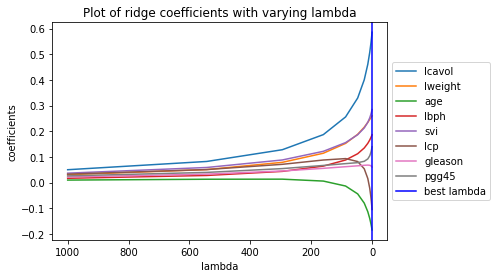

In [20]:
# Plot of ridge coefficients against lambda

ax=plt.gca()
for i in range(1, len(coefficients)):
  ax.plot(lambdas, coefficients[i, :], label=str(feature_names[i]))
plt.axvline(x = min_lambda, color = 'b', label = 'best lambda')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_xaxis()

plt.xlabel("lambda")
plt.ylabel("coefficients")
plt.title("Plot of ridge coefficients with varying lambda")
plt.show()

3. Lasso Regression

In [21]:
lambdas = list(np.logspace(-8, 0.01))
# lambdas = [0.00001, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1.0, 10]
# lambdas = [1e-8, 1e-7, 1e-6, 0.00001, 0.0001, 1e-2, 0.1, 1]

min_lambda_lasso = 0
min_mse_lasso = sys.float_info.max
models = []
coefficients_lasso = np.zeros((x_train.shape[1], len(lambdas)))

for i, lamb in enumerate(lambdas):
  lasso_model = linear_model.Lasso(alpha=lamb)
  lasso_model.fit(x_train, y_train)
  coefficients_lasso[:, i] = np.transpose(lasso_model.coef_) # bad practice?
  mse_lasso = mean_squared_error(lasso_model.predict(x_val), y_val) 
  if mse_lasso < min_mse_lasso:
    min_lambda_lasso = lamb
    min_mse_lasso = mse_lasso
    models.append(lasso_model)

In [22]:
lasso_model_test = models[0]

y_hat = lasso_model_test.predict(x_train)
mse_lasso = mean_squared_error(y_hat, y_train)

print("MSE of Lasso Regression on training set: " + str(mse_lasso))

y_hat = lasso_model_test.predict(x_test)
mse_lasso = mean_squared_error(y_hat, y_test)

print("MSE of Lasso Regression on test set: " + str(mse_lasso))

MSE of Lasso Regression on training set: 0.42054657698467585
MSE of Lasso Regression on test set: 0.4597676768734785


For lasso regression, the mean squared error is also higher on the test set than the training set.

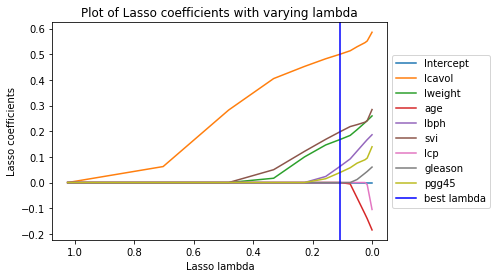

In [23]:
# Plot Lasso coefficients
ax=plt.gca()
for i in range(len(feature_names)):
  plt.plot(lambdas, coefficients_lasso[i,:], label=feature_names[i])
plt.axvline(x = min_lambda_lasso, color = 'b', label = 'best lambda')
ax.invert_xaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Lasso lambda")
plt.ylabel("Lasso coefficients")
plt.title("Plot of Lasso coefficients with varying lambda")
plt.show()

**Part 2**

Dataset from: https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction

In [24]:
# Import data
from google.colab import files
uploaded = files.upload()

Saving Real estate.csv to Real estate (4).csv


In [25]:
import io
data2 = pd.read_csv(io.BytesIO(uploaded['Real estate.csv']), index_col=0)

In [26]:
features2 = ['intercept'] + [col for col in data2.columns if col != "No" and col != "Y house price of unit area"]

In [27]:
features2_corr = [col for col in data2.columns if col != "No" and col != "Y house price of unit area"]
data2[features2_corr].corr()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
X1 transaction date,1.000000,0.017549,0.060880,0.009635,0.035058,-0.041082
X2 house age,0.017549,1.000000,0.025622,0.049593,0.054420,-0.048520
X3 distance to the nearest MRT station,0.060880,0.025622,1.000000,-0.602519,-0.591067,-0.806317
X4 number of convenience stores,0.009635,0.049593,-0.602519,1.000000,0.444143,0.449099
X5 latitude,0.035058,0.054420,-0.591067,0.444143,1.000000,0.412924
X6 longitude,-0.041082,-0.048520,-0.806317,0.449099,0.412924,1.000000


In [28]:
# Separate target value from pandas dataframe
data2_num = data2.shape[0]
raw_train = data2[list(col for col in data2.columns if col != "No" and col != "Y house price of unit area")]
train_data_2 = np.concatenate((np.ones((data2_num, 1)), raw_train.to_numpy()), axis=1)
test_data_2 = data2['Y house price of unit area'].to_numpy().reshape(data2.shape[0], 1)

In [29]:
# Split dataset to train, validation, test
# Train : validation : test = 331 : 41 : 42
x_train2, x_test2, y_train2, y_test2 = train_test_split(train_data_2, test_data_2, test_size=0.2)
x_val2, x_test2, y_val2, y_test2 = train_test_split(x_test2, y_test2, test_size = 0.5)


In [30]:
# # Normalize train, validation, and test features
x_train2_mean = np.zeros(x_train2.shape[1])
x_train2_std = np.zeros(x_train2.shape[1])
for i in range(1, x_train2.shape[1]):
  x_train2_mean[i] = np.mean(x_train2[:,i])
  x_train2_std[i] = np.std(x_train2[:,i])

x_train2 = normalize(x_train2, x_train2_mean, x_train2_std)
x_val2 = normalize(x_val2, x_train2_mean, x_train2_std)
x_test2 = normalize(x_test2, x_train2_mean, x_train2_std)

In [31]:
beta_hat2 = beta_hat_func(x_train2, y_train2)
y_hat2 = np.matmul(x_test2, beta_hat2)

In [32]:
#MSE on training dataset
y_hat_train = np.matmul(x_train2, beta_hat2)
mse_train = mean_squared_error(y_hat_train, y_train2)
print("Mean squared error on training set: ", mse_train)

mse_plain2 = mean_squared_error(y_hat2, y_test2)
print("Mean squared error on test: ", mse_plain2)

Mean squared error on training set:  80.25964571642803
Mean squared error on test:  93.52494048953523


MSE of training set is smaller than MSE of test set. 

In [33]:
z_score2 = [0.0 for _ in range(len(features2))]
x_squared2 = np.linalg.inv(np.matmul(np.transpose(x_train2), x_train2))
N2 = x_train2.shape[0]
p2 = x_train2.shape[1]
var2 = 1/(N2-p2-1)*np.sum((y_test2 - y_hat2)**2)
stdev2 = np.sqrt(var2)


for i in range(len(z_score2)):
  z_score2[i] = np.round(beta_hat2[i] / (stdev2*np.sqrt(x_squared2[i, i])), 2)  


In [34]:
table2 = [["Term", "Coefficient", "Std Error", "Z Score"]]
for i in range(len(features2)):
  table2.append([features2[i], str(beta_hat2[i]), str(np.round(x_train2_std[i] / len(x_train2), 2)), str(z_score2[i])])
print(tabulate(table2, headers='firstrow'))

Term                                    Coefficient      Std Error  Z Score
--------------------------------------  -------------  -----------  ---------
intercept                               [38.03927492]         0     [198.45]
X1 transaction date                     [1.7377251]           0     [8.98]
X2 house age                            [-3.15136494]         0.03  [-16.39]
X3 distance to the nearest MRT station  [-5.39122665]         3.67  [-13.74]
X4 number of convenience stores         [3.00393894]          0.01  [12.24]
X5 latitude                             [2.82759341]          0     [11.79]
X6 longitude                            [0.17573653]          0     [0.54]


**Ridge Regression**

In [35]:
lambdas = list(np.logspace(-5, 4.5))
# lambdas = [0.00001, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1.0, 10]
# lambdas = [1e-8, 1e-7, 1e-6, 0.00001, 0.0001, 1e-2, 0.1, 1]

coefficients = np.zeros((x_train2.shape[1], len(lambdas)))
min_lambda = 0
min_rss_ridge = sys.float_info.max
min_beta_ridge = 0

for i, lamb in enumerate(lambdas):
  beta_ridge_lamb = beta_hat_ridge(x_train2, y_train2, lamb)
  rss_ridge_lamb = rss_ridge(x_val2, y_val2, beta_ridge_lamb, lamb)
  coefficients[:, i] = np.transpose(beta_ridge_lamb)

  # Pick lambda that makes RSS_ridge the smallest
  if rss_ridge_lamb < min_rss_ridge:
    min_rss_ridge = rss_ridge_lamb
    min_lambda = lamb
    min_beta_ridge = beta_ridge_lamb


In [36]:
#MSE on training dataset
y_hat_train = np.matmul(x_train2, min_beta_ridge) 
mse_ridge_train = mean_squared_error(y_train2, y_hat_train)

print("MSE of Ridge Regression on training set: ", mse_ridge_train)

#MSE on test dataset
y_hat = np.matmul(x_test2, min_beta_ridge) 
mse_ridge = mean_squared_error(y_test2, y_hat)

print("MSE of Ridge Regression on test set: ", mse_ridge)

MSE of Ridge Regression on training set:  80.25964571642943
MSE of Ridge Regression on test set:  93.52494342216204


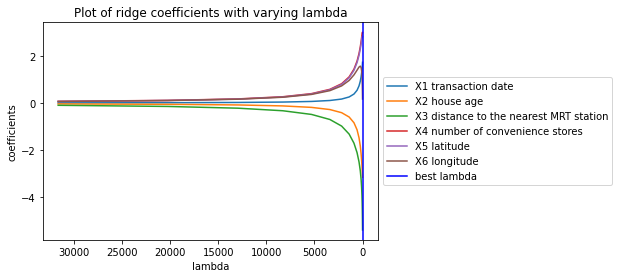

In [37]:
# Plot of ridge coefficients against lambda
ax=plt.gca()
for i in range(1, len(coefficients)):
  ax.plot(lambdas, coefficients[i, :], label=str(features2[i]))
  
plt.axvline(x = min_lambda, color = 'b', label = 'best lambda')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_xaxis()

plt.xlabel("lambda")
plt.ylabel("coefficients")
plt.title("Plot of ridge coefficients with varying lambda")
plt.show()

It appears from the plot that number of convenience stores and latitude are important to unit house price and distance to the nearest mrt station is the least important.

**Lasso Regression**

In [38]:
# Loop through multiple lambdas and select lambda that minimizes RSS
lambdas = list(np.logspace(-5, 1))

# lambdas = [0.00001, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1.0, 10, 1000]

min_lambda_lasso2 = 0
min_mse_lasso2 = sys.float_info.max
models2 = []
coefficients_lasso2 = np.zeros((x_train2.shape[1], len(lambdas)))

for i, lamb in enumerate(lambdas):
  lasso_model2 = linear_model.Lasso(alpha=lamb)
  lasso_model2.fit(x_train2, y_train2)
  coefficients_lasso2[:, i] =  np.transpose(lasso_model2.coef_) # bad practice?
  mse_lasso2 = mean_squared_error(lasso_model2.predict(x_val2), y_val2) 
  if mse_lasso2 < min_mse_lasso2:
    min_lambda_lasso2 = lamb
    min_mse_lasso2 = mse_lasso2
    models2.append(lasso_model2)

In [39]:
lasso_model_test2 = models2[0]
y_hat2 = lasso_model_test2.predict(x_test2)

In [40]:
#MSE on training dataset
y_hat2_train = lasso_model_test2.predict(x_train2)
mse_lasso2_train = mean_squared_error(y_hat2_train, y_train2)
print("MSE of Lasso Regression on train dataset: " + str(mse_lasso2_train))

mse_lasso2 = mean_squared_error(y_hat2, y_test2)

print("MSE of Lasso Regression on test dataset: " + str(mse_lasso2))

MSE of Lasso Regression on train dataset: 80.25964571774605
MSE of Lasso Regression on test dataset: 93.52493092073587


MSE of Lasso regression on train is smaller than that of test. MSE is generally greater than that of prostate data and I assume that is due to the fact that real estate price is not as linear as prostate data

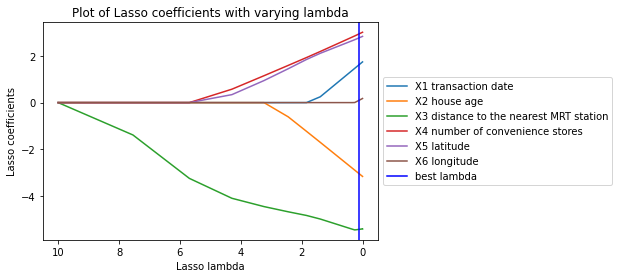

In [41]:
# Plot Lasso coefficients
ax=plt.gca()
for i in range(1, len(features2)):
  plt.plot(lambdas, coefficients_lasso2[i,:], label=features2[i])
plt.axvline(x = min_lambda_lasso, color = 'b', label = 'best lambda')
ax.invert_xaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Lasso lambda")
# plt.ylim(-1,5)
plt.ylabel("Lasso coefficients")
plt.title("Plot of Lasso coefficients with varying lambda")
plt.show()

Of the features sets of real estate price prediction, the Lasso coefficient was the largest for latitude, transaction date, and number of convenience stores. It makes sense that the number of convenience stores and transaction date affect unit house price because more convenience stores nearby means popular area and there can be market price change in real estates at different times. However, it is not very intuitive that latitude affects unit house price the most. This can due to the fact that real estate price is not always linear and is affected by many other factors.

In [42]:
# Interactive terms of longitude and latitute for training data
int_term1 = (x_train2[:,-2] * x_train2[:,-1]).reshape(x_train2.shape[0], 1)

# Interactive terms of longitude and number of convenience stores for training data
int_term2 = (x_train2[:,4] * x_train2[:,-1]).reshape(x_train2.shape[0], 1)

train_data_2_int = np.concatenate((x_train2, int_term1, int_term2), axis=1)

In [43]:
# Interactive terms of longitude and latitute for test data
int_term1_test = (x_test2[:,-2] * x_test2[:,-1]).reshape(x_test2.shape[0], 1)

# Interactive terms of longitude and number of convenience stores for test data
int_term2_test = (x_test2[:,4] * x_test2[:,-1]).reshape(x_test2.shape[0], 1)

test_data_2_int = np.concatenate((x_test2, int_term1_test, int_term2_test), axis=1)

In [44]:
from sklearn.linear_model import LassoCV

lasso_int = LassoCV(cv=5, n_alphas=500).fit(train_data_2_int, y_train2)
y_hat = lasso_int.predict(test_data_2_int)
y_hat_train = lasso_int.predict(train_data_2_int)

mse_lasso_int = mean_squared_error(y_hat, y_test2)
mse_lasso_int_train = mean_squared_error(y_hat_train, y_train2)

print("MSE of Lasso with interactive term of test data: " + str(mse_lasso_int))
print("MSE of Lasso with interactive term of training data: " + str(mse_lasso_int_train))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE of Lasso with interactive term of test data: 77.67479973435394
MSE of Lasso with interactive term of training data: 70.11381294401812


The variables to participate in interactive terms are chosen based on the correlation table of predictors we got from plain linear regression. The correlation was the largest for longitude and latitude and for longitude and number of convenience stores so they were used as nonlinear interactive terms. These terms were "appended" at the end of the dataset and fed into Lasso model just like plain Lasso regression. 

The result showed that the test error reduced by almost 30 percent compared to the test error of plain Lasso regression. However, it has to be noted that the features were normalized when using interactive terms because the values might get too high during multiplication. Adding nonlinear interactive terms did improve the performance. 